In [10]:
import readline

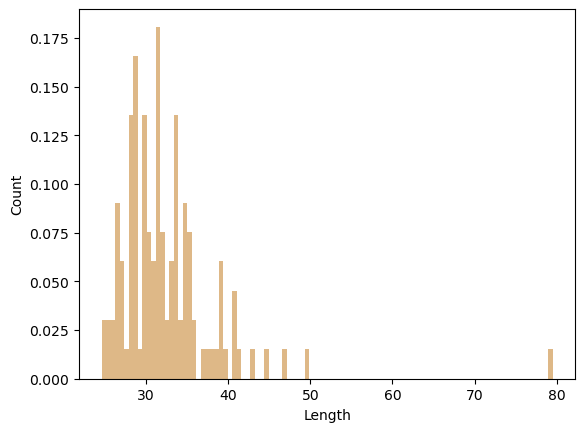

20.458168029785156 43.04212188720703


tckedit: [WARNING] existing output files will be overwritten
tckedit: [done]      121 read,        0 written
tckedit: [WARNING] existing output files will be overwritten
tckedit: [done]      121 read,        5 written
tckedit: [WARNING] existing output files will be overwritten
tckedit: [done]        5 read,        5 written
tckedit: [WARNING] existing output files will be overwritten
tckedit: [done]      121 read,      117 written


In [43]:
import nibabel as nib
from dipy.io.streamline import load_tractogram, save_trk
from dipy.tracking.utils import length
import numpy as np
import subprocess
import os

tract_path = "../study/subjects/VNSLC_19/dMRI/tractography/right-thalamus-Insula.tck"
# remotion of outliers IQR rule
trk = nib.streamlines.load(tract_path).tractogram
bundle  = trk.streamlines

lengths = list(length(bundle))

import matplotlib.pyplot as plt

fig_hist, ax = plt.subplots(1)
ax.hist(lengths, color='burlywood', bins=100, density=True)
ax.set_xlabel('Length')
ax.set_ylabel('Count')
plt.show()

q1 = np.quantile(lengths, 0.25)
q3 = np.quantile(lengths, 0.75)
iqr = q3 - q1
upper = q3 + 1.5*iqr
lower = q1 - 1.5*iqr
print(lower, upper)

cmd = "tckedit -maxlength %f -force %s %s && tckedit -minlength %f -force %s %s && tckedit -force %s %s %s" % (lower, tract_path, "../lower.tck", upper, tract_path, "../upper.tck", "../lower.tck", "../upper.tck", "../removed.tck")
process = subprocess.Popen(cmd, stdout=subprocess.PIPE, shell=True)
process.wait()
os.remove("../lower.tck"); os.remove("../upper.tck")

tract = load_tractogram("../removed.tck", "../study/subjects/VNSLC_19/dMRI/preproc/VNSLC_19_dmri_preproc.nii.gz")
save_trk(tract, "../removed.trk")

cmd = "tckedit -minlength %f -maxlength %f -force %s %s" % (lower, upper,tract_path, "../prova.tck")
process = subprocess.Popen(cmd, stdout=subprocess.PIPE, shell=True)
process.wait()

tract = load_tractogram("../prova.tck", "../study/subjects/VNSLC_19/dMRI/preproc/VNSLC_19_dmri_preproc.nii.gz")
save_trk(tract, "../prova.trk")

In [33]:
a = np.array([1.5])
np.round(a).astype(int)


array([2])

laplace -------------
---------------------
MEAN---------------
numpy:	 0.042745350986886324
scipy:	 0.042745350986886324
pandas:	 0.042745350986886324
stats:	 0.04274535098688635
mine:	 0.04274535098688635
alt:	 0.04410040946696763
numpyW:	 0.026143264978111334
mine_W:	 0.026143264978111345
statsm:	 0.026143264978111345
repeat:	 0.02610408872423121
alt_w:	 0.025853882509928254
STD ---------------
numpy:	 1.4594488156301868
scipy:	 1.460179087787785
pandas:	 1.460179087787785
stats:	 1.4594488156301868
mine:	 1.460179087787785
mineW:	 1.3985834240679984
statsm:	 1.3976269407109336
repeat:	 1.3975683130777852
alt_W:	 1.3985174813505792
SKEW ---------------
scipy:	 -0.04628911704139415
pandas:	 -0.04628911704139414
mine:	 -0.051585808900118504
KURT ---------------
scipy:	 3.1327868718532805
pandas:	 3.132786871853281
pandas:	 3.132786871853281
mine:	 3.1157619661271116

norm -------------
---------------------
MEAN---------------
numpy:	 -0.038847911805857276
scipy:	 -0.03884791180585727

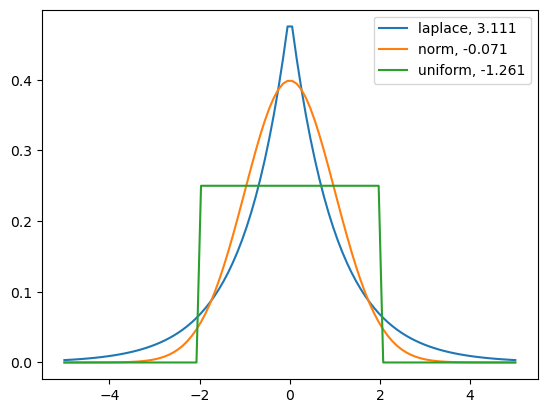

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from metrics import w_kurt, w_mean, w_var, w_skew, w_mean_alt, w_std_alt
from statsmodels.stats.weightstats import DescrStatsW

x = np.linspace(-5, 5, 100)
ax = plt.subplot()
distnames = ['laplace', 'norm', 'uniform']

for distname in distnames:
    if distname == 'uniform':
        dist = getattr(stats, distname)(loc=-2, scale=4)
    else:
        dist = getattr(stats, distname)
    data = dist.rvs(size=1000)
    kur = stats.kurtosis(data, fisher=True)
    y = dist.pdf(x)
    ax.plot(x, y, label="{}, {}".format(distname, round(kur, 3)))
    ax.legend()

    weights = np.random.rand(data.size)

    dstat = DescrStatsW(data.ravel(), weights.ravel())
    dstatno = DescrStatsW(data.ravel(), np.ones(data.size))

    weights_scal = (weights-weights.min())/(weights.max()-weights.min())*(1000-0)+0
    weights_scal = np.round(weights_scal).astype(int)
    repeat = np.repeat(data, weights_scal)

    print(distname, "-------------")
    print("---------------------")

    print("MEAN---------------")
    print("numpy:\t", np.mean(data))
    print("scipy:\t", stats.tmean(data))
    print("pandas:\t", pd.DataFrame(data).mean(axis=0)[0])
    print("stats:\t", dstatno.mean)
    print("mine:\t", w_mean(data, np.ones(data.size)))
    print("alt:\t", w_mean_alt(data, np.ones(data.size)))
    print("numpyW:\t", np.average(data, weights=weights))
    print("mine_W:\t", w_mean(data, weights))
    print("statsm:\t", dstat.mean)
    print("repeat:\t", np.mean(repeat))
    print("alt_w:\t", w_mean_alt(data, weights))

    print ("STD ---------------")
    print("numpy:\t", np.std(data))
    print("scipy:\t", stats.tstd(data))
    print("pandas:\t", pd.DataFrame(data).std(axis=0)[0])
    print("stats:\t", dstatno.std)
    print("mine:\t", np.sqrt(w_var(data, np.ones(data.size))))
    print("mineW:\t", np.sqrt(w_var(data, weights)))
    print("statsm:\t", dstat.std)
    print("repeat:\t", np.std(repeat))
    print("alt_W:\t", w_std_alt(data, weights))

    print ("SKEW ---------------")
    print("scipy:\t", stats.skew(data,bias=False))
    print("pandas:\t", pd.DataFrame(data).skew(axis=0)[0])
    print("mine:\t", w_skew(data, np.ones(data.size)))

    print("KURT ---------------")
    print("scipy:\t", stats.kurtosis(data, fisher=True, bias=False))
    print("pandas:\t", pd.DataFrame(data).kurtosis(axis=0)[0])
    print("pandas:\t", pd.DataFrame(data).kurt(axis=0)[0])
    print("mine:\t", w_kurt(data, np.ones(data.size)))

    print()


In [284]:
from scipy import stats

stats.kurtosis([1,1,1], bias=False)

/tmp/ipykernel_400150/3228002891.py:3: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stats.kurtosis([1,1,1], bias=False)


nan

In [283]:
from metrics import *

a = np.array([0,1,1,1, 2])
w = np.array([0.001,0.5, 0.5, 0.5, 0.001])

print(w_mean(a, w))
print(np.sqrt(w_var(a, w)))
print(w_skew(a, w))


1.0000000000000002
0.0446618994896346
0.0


Prove sulla density map, cos'è megli o???

In [1]:
import os
from dipy.io.streamline import load_tractogram
from unravel.utils import *
from nibabel import Nifti1Image
import nibabel as nib

from metrics import correctWeightsTract


subj_path = "../study/subjects/VNSLC_02/"
trk_path = subj_path + "dMRI/tractography/left-sup-longi-fasci.trk"
#mask_path = subj_path + "masks/VNSLC_02_Right-Hippocampus-TrilInterp_aparc+aseg.nii.gz"
metric_path = subj_path + "dMRI/microstructure/dti/VNSLC_02_FA.nii.gz"

#mask_map : Nifti1Image = nib.load(mask_path)

metric_map : Nifti1Image = nib.load(metric_path)
affine_info = metric_map.affine

trk = load_tractogram(trk_path, "same")
trk.to_vox()
trk.to_corner()

density_map = get_streamline_density(trk)


100%|██████████| 16887/16887 [03:50<00:00, 73.32it/s]


In [2]:
density_map_norm = density_map / density_map.sum()
nib.save(nib.Nifti1Image((density_map_norm>0)+0.0, affine_info), "../density_noCorr.nii.gz")

In [16]:
density_thres = density_map / density_map.max() # normalize by maximum streamlines in a voxel

# with just one line we want to ge the voxels that have
# at least 2/3 of all the stream lines, and since the maximum
# value that a voxel can have is sqrt(3) [the diagonal] 
# the threshold will filter all the voxels with value < 2/3
# The value of the threshold change depending on how many streamlines
# are present 
density_thres[density_thres<0.10] = 0

density_thres = density_thres / density_thres.sum() #normalize

density_thres = density_thres * np.exp(density_thres)
density_thres = density_thres / density_thres.sum() #normalize

nib.save(nib.Nifti1Image(density_thres, affine_info), "../density_thres.nii.gz")

In [3]:
from metrics import correctWeightsTract

density_test = correctWeightsTract(density_map, get_streamline_count(trk))

nib.save(nib.Nifti1Image((density_test>0)+0.0, affine_info), "../test.nii.gz")

0.7


In [17]:
get_streamline_count(trk)

16887

In [12]:
from metrics import mostImportant

density_most = mostImportant(density_test)

nib.save(nib.Nifti1Image(density_most, affine_info), "../mostImportant.nii.gz")

In [10]:
from metrics import *

metric_np = metric_map.get_fdata()
mask_np = mask_map.get_fdata()

print(metric_np.shape)
print(mask_np.shape)
u = w_mean(metric_np, mask_np)
skew = w_skew(metric_np, mask_np)
std = np.sqrt(w_var(metric_np, mask_np))
kurt = w_kurt(metric_np, mask_np)

print("mean:", u,"std:", std,"skew:",skew,"kurt:",kurt)


(110, 110, 68)
(110, 110, 68)
mean: 0.0005721573204361296 std: 0.00038609001196202047 skew: 48.45579035518214 kurt: 2714.3767560295587


In [39]:
mask_bool = mask_np > 0
print(metric_np[mask_np>0].max())
print(metric_np[mask_bool>0].min())
metric_np[mask_np>0].mean()

stats.kurtosis(metric_np[mask_np>0], fisher=True, bias=False)


0.02399916760623455
6.268300694500795e-06


538.1720387665401

In [5]:
def decresingSigmoid(X, min=0.1, max=0.5, flex=50, smooth=10):
    """
    Every unit of the smothing the funcion si dilated by 5 from a side
    """
    def sig(X):
        return 1/(1+np.exp(-X))
    return sig(-(X-flex)/smooth)*(max-min)+min 

decresingSigmoid(2)

0.496734971538736

# Image analysis

In [27]:
import nibabel as nib
from nibabel import Nifti1Image

T1s_path = "../study/T1/"
T1_path = T1s_path + "VNSLC_01_T1.nii.gz"
T2_path = T1s_path + "VNSLC_01_T2.nii.gz"

dmris_path = "../study/data_1/"
dmri_path = dmris_path + "VNSLC_01.nii.gz"


t1 : Nifti1Image = nib.load(T1_path)
t2 : Nifti1Image = nib.load(T2_path)
dmri = Nifti1Image = nib.load(dmri_path)

t1_np = t1.get_fdata()
t2_np = t2.get_fdata()
dmri_np = dmri.get_fdata()

In [28]:
print("t1", t1.shape, "\nt2", t2.shape, "\ndmri:", dmri.shape)

t1 (156, 256, 256) 
t2 (142, 256, 256) 
dmri: (110, 110, 68, 167)


In [30]:
import nibabel as nib
from nibabel import Nifti1Image

subj = "VNSLC_19"
subj_path = "../study/subjects/%s/" % subj
fornix = subj_path+"masks/%s_Both-Fornix_Atlas-Merge.nii.gz" % subj
left_cingulum = subj_path+"masks/%s_Left-Cingulum_Atlas-Merge.nii.gz" % subj
right_cingulum = subj_path+"masks/%s_Right-Cingulum_Atlas-Merge.nii.gz" % subj
mam_body = subj_path+"masks/%s_Both-Mammillary-body_Atlas-Merge.nii.gz" % subj

# load the maps
fornix_map : Nifti1Image = nib.load(fornix)
left_cingulum_map : Nifti1Image = nib.load(left_cingulum)
right_cingulum_map : Nifti1Image = nib.load(right_cingulum)
mam_map : Nifti1Image = nib.load(mam_body)

# to numpy array
fornix_np = fornix_map.get_fdata()
left_cingulum_np = left_cingulum_map.get_fdata()
right_cingulum_np = right_cingulum_map.get_fdata()
mam_np = mam_map.get_fdata()

# binarization
fornix_np[fornix_np>0] = 1
left_cingulum_np[left_cingulum_np>0] = 1
right_cingulum_np[right_cingulum_np>0] = 1
mam_np[mam_np>0] = 1

# save the maps 
nib.save(nib.Nifti1Image(fornix_np, fornix_map.affine), "../bin_fornix.nii.gz")
nib.save(nib.Nifti1Image(left_cingulum_np, left_cingulum_map.affine), "../bin_left_cingulum.nii.gz")
nib.save(nib.Nifti1Image(right_cingulum_np, right_cingulum_map.affine), "../bin_right_cingulum.nii.gz")
nib.save(nib.Nifti1Image(mam_np, mam_map.affine), "../bin_mam.nii.gz")


In [3]:
import nibabel as nib
from nibabel import Nifti1Image
from dipy.io.streamline import load_tractogram
from unravel.core import *
from unravel.utils import *
from metrics import correctWeightsTract

subj = "VNSLC_02"
subj_path = "../study/subjects/%s/" % subj
left_fornix_rmd_path = subj_path+"dMRI/tractography/left-fornix_rmvd.trk"
right_fornix_rmd_path = subj_path+"dMRI/tractography/right-fornix_rmvd.trk"
left_fornix_path = subj_path+"dMRI/tractography/left-fornix.trk"
right_fornix_path = subj_path+"dMRI/tractography/right-fornix.trk"

# load something for affine informations
ODF_path = subj_path + "dMRI/ODF/MSMT-CSD/%s_MSMT-CSD_WM_ODF.nii.gz" % subj
odf_map : Nifti1Image = nib.load(ODF_path)

left_fornix_rmd = load_tractogram(left_fornix_rmd_path, "same")
right_fornix_rmd = load_tractogram(right_fornix_rmd_path, "same")
left_fornix = load_tractogram(left_fornix_path, "same")
right_fornix = load_tractogram(right_fornix_path, "same")

left_fornix_rmd.to_vox(); left_fornix_rmd.to_corner()
right_fornix_rmd.to_vox(); right_fornix_rmd.to_corner()
left_fornix.to_vox(); left_fornix.to_corner()
right_fornix.to_vox(); right_fornix.to_corner()

left_fornix_rmd_density = get_streamline_density(left_fornix_rmd)
right_fornix_rmd_density = get_streamline_density(right_fornix_rmd)
left_fornix_density = get_streamline_density(left_fornix)
right_fornix_density = get_streamline_density(right_fornix)

# fornix U removed streams to get the starting point
left_fornix_start_density = left_fornix_rmd_density + left_fornix_density
right_fornix_start_density = right_fornix_rmd_density + right_fornix_density

# binarization
left_fornix_start_density[left_fornix_start_density>0] = 1
right_fornix_start_density[right_fornix_start_density>0] = 1

# second step of thresholding the voxels
left_fornix_density_correcter = correctWeightsTract(left_fornix_density)
right_fornix_density_correcter = correctWeightsTract(right_fornix_density)

# fornix after the first step and binarization of it
left_fornix_density[left_fornix_density>0] = 1
right_fornix_density[right_fornix_density>0] = 1

# binarization the second step
left_fornix_density_correcter[left_fornix_density_correcter>0] = 1
right_fornix_density_correcter[right_fornix_density_correcter>0] = 1

# save all
nib.save(nib.Nifti1Image(left_fornix_start_density, odf_map.affine), "../left_fornix_start.nii.gz")
nib.save(nib.Nifti1Image(right_fornix_start_density, odf_map.affine), "../right_fornix_start.nii.gz")
nib.save(nib.Nifti1Image(left_fornix_density, odf_map.affine), "../left_fornix.nii.gz")
nib.save(nib.Nifti1Image(right_fornix_density, odf_map.affine), "../right_fornix.nii.gz")
nib.save(nib.Nifti1Image(left_fornix_density_correcter, odf_map.affine), "../left_fornix_final.nii.gz")
nib.save(nib.Nifti1Image(right_fornix_density_correcter, odf_map.affine), "../right_fornix_final.nii.gz")


NameError: name 'left_fornix_rmd_density' is not defined

# Tck 2 Trk

In [1]:
from dipy.io.streamline import load_tractogram, save_trk


subj = "VNSLC_02"
subj_path = "../study/subjects/%s/" % subj
tck_path = "../left-Thalamus-Radiation.tck"
odf_path = subj_path+"dMRI/ODF/MSMT-CSD/%s_MSMT-CSD_WM_ODF.nii.gz" % subj
out_path = "../left-Thalamus-Radiation.trk"

tract = load_tractogram(tck_path, odf_path)
save_trk(tract, out_path)

# wFVF

In [1]:
import nibabel as nib
from nibabel import Nifti1Image
from metrics import *

subj = "VNSLC_02"
subj_path = "../study/subjects/%s/" % subj
mf_fold = subj_path + "/dMRI/microstructure/mf/"
diamond_fold = subj_path + "/dMRI/microstructure/diamond/"

save_mf_wfvf(mf_fold, subj)
save_DIAMOND_cMap_wMap_divideFract(diamond_fold, subj)

In [48]:
subj = "VNSLC_07"
subj_path = "../study/subjects/%s/" % subj
density_path = subj_path + "masks/"+subj+"_right-thalamus-AntCingCtx_tract.nii.gz"
fa_path = subj_path + "dMRI/microstructure/dti/"+subj+"_FA.nii.gz"

density = nib.load(density_path).get_fdata()
fa = nib.load(fa_path).get_fdata()

v = fa.ravel()
w = density.ravel()

np.average(v, weights=w)

0.5667303915868287

In [33]:
import nibabel as nib
from dipy.tracking.utils import length

tck_path = "/home/michele/Dropbox (Politecnico Di Torino Studenti)/thesis/code/Epilepsy-dMRI-VNS/study/subjects/VNSLC_03/dMRI/tractography/left-thalamus-AntCingCtx.tck"

tck_path_rem = "/home/michele/Dropbox (Politecnico Di Torino Studenti)/thesis/code/Epilepsy-dMRI-VNS/study/subjects/VNSLC_03/dMRI/tractography/left-thalamus-AntCingCtx_rmvd.tck"

bundle  = nib.streamlines.load(tck_path).streamlines
lengths = list(length(bundle))

print(list(length(nib.streamlines.load(tck_path_rem).streamlines)))

[143.31618, 143.31618]


In [37]:
q1 = np.quantile(lengths, 0.30)
q3 = np.quantile(lengths, 0.70)
iqr = q3 - q1
upper = q3 + 1.5*iqr
lower = q1 - 1.5*iqr

print(lower, upper)

print(lengths)

132.24455070495605 150.43749809265137
[143.31618, 146.30583, 116.045845, 141.6248]


In [73]:
import os
from dipy.io.streamline import load_tractogram
from unravel.utils import *
from nibabel import Nifti1Image
import nibabel as nib
import seaborn as sns

trk_path = "/home/michele/Dropbox (Politecnico Di Torino Studenti)/thesis/code/Epilepsy-dMRI-VNS/study/subjects/VNSLC_03/dMRI/tractography/right-fornix.trk"

trk = load_tractogram(trk_path, "same")
trk.to_vox()
trk.to_corner()

density_map = get_streamline_density(trk)
angle_map = get_streamline_angle(trk)

100%|██████████| 6/6 [00:00<00:00, 58.29it/s]


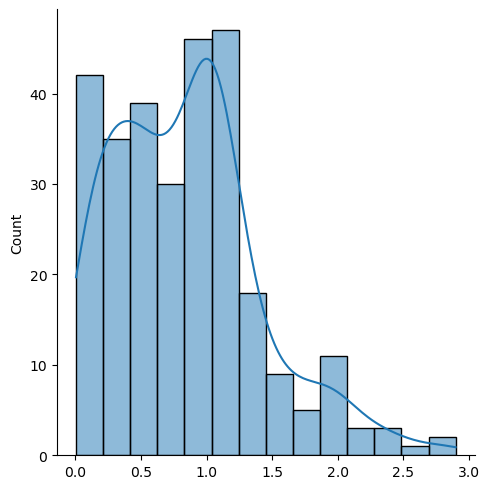

In [74]:
distr = density_map[density_map>0]
sns.displot(distr, kde=True)

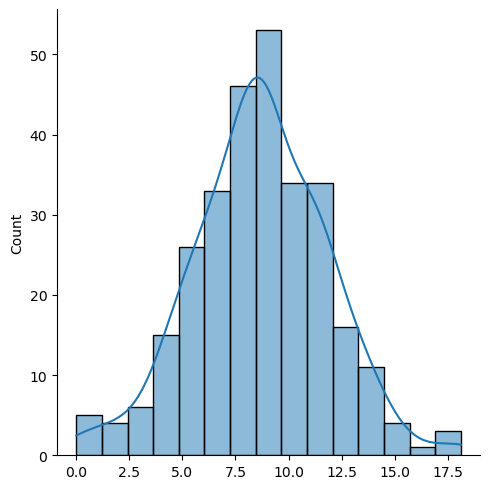

In [72]:
distr = angle_map[density_map>0]
sns.displot(distr, kde=True)

In [63]:
from scipy import stats

stats.kurtosis(distr, fisher=True, bias=False)

0.733464241027832

# Convolution for couinting the neighbours 


In [95]:
import os
from dipy.io.streamline import load_tractogram
from unravel.utils import *
from nibabel import Nifti1Image
import nibabel as nib
import seaborn as sns
from scipy import signal

trk_path = "/home/michele/Dropbox (Politecnico Di Torino Studenti)/thesis/code/Epilepsy-dMRI-VNS/study/subjects/VNSLC_02/dMRI/tractography/left-fornix.trk"

metric_path = "/home/michele/Dropbox (Politecnico Di Torino Studenti)/thesis/code/Epilepsy-dMRI-VNS/study/subjects/VNSLC_02/dMRI/microstructure/diamond/VNSLC_02_diamond_frac_ctot.nii.gz"

metric_map : Nifti1Image = nib.load(metric_path)
affine_info = metric_map.affine

trk = load_tractogram(trk_path, "same")
trk.to_vox()
trk.to_corner()

density_map = get_streamline_density(trk)
out_path = "/home/michele/Dropbox (Politecnico Di Torino Studenti)/thesis/code/Epilepsy-dMRI-VNS/study/subjects/VNSLC_02/masks/VNSLC_02_right-fornix_tractNoCorrBin.nii.gz"
bin = density_map.copy()
bin[bin>0] = 1
nib.save(nib.Nifti1Image(bin, affine_info), out_path)

kernel = [[[1/2, 1/2, 1/2],
           [1/2, 1/2, 1/2],
           [1/2, 1/2, 1/2]],
          [[1/2, 1/2, 1/2],
           [1/2, 1  , 1/2],
           [1/2, 1/2, 1/2]],
          [[1/2, 1/2, 1/2],
           [1/2, 1/2, 1/2],
           [1/2, 1/2, 1/2]]]
kernel = np.array(kernel)

c = signal.convolve(density_map, kernel, mode="same", method="direct")

out_path = "/home/michele/Dropbox (Politecnico Di Torino Studenti)/thesis/code/Epilepsy-dMRI-VNS/study/subjects/VNSLC_03/masks/VNSLC_03_right-fornix_tractNoCorrConv.nii.gz"
nib.save(nib.Nifti1Image(c, affine_info), out_path)

out_path = "/home/michele/Dropbox (Politecnico Di Torino Studenti)/thesis/code/Epilepsy-dMRI-VNS/study/subjects/VNSLC_03/masks/VNSLC_03_right-fornix_tractNoCorrConvScaled.nii.gz"
c_scal = (c - c.min())/(c.max() - c.min())
nib.save(nib.Nifti1Image(c_scal, affine_info), out_path)

out_path = "/home/michele/Dropbox (Politecnico Di Torino Studenti)/thesis/code/Epilepsy-dMRI-VNS/study/subjects/VNSLC_03/masks/VNSLC_03_right-fornix_tractConv.nii.gz"
c_corr = c.copy()
c_corr[c_scal<0.45] = 0
nib.save(nib.Nifti1Image(c_corr, affine_info), out_path)

out_path = "/home/michele/Dropbox (Politecnico Di Torino Studenti)/thesis/code/Epilepsy-dMRI-VNS/study/subjects/VNSLC_03/masks/VNSLC_03_right-fornix_tractConvMapBin.nii.gz"
fasci_mask = metric_map.get_fdata()
fasci_mask[fasci_mask > 0] = 1
c_corrMap = c_corr*fasci_mask
c_corrMap[c_corrMap>0] = 1 # Binariazion for visualization
nib.save(nib.Nifti1Image(c_corrMap, affine_info), out_path)

c_corrMap[density_map == 0] = 0
out_path = "/home/michele/Dropbox (Politecnico Di Torino Studenti)/thesis/code/Epilepsy-dMRI-VNS/study/subjects/VNSLC_03/masks/VNSLC_03_right-fornix_tractConvMapFiltrBin.nii.gz"
nib.save(nib.Nifti1Image(c_corrMap, affine_info), out_path)



  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 26.86it/s]


In [6]:
import nibabel as nib
import numpy as np

mask_path = "/home/michele/Dropbox (Politecnico Di Torino Studenti)/thesis/code/Epilepsy-dMRI-VNS/study/subjects/VNSLC_02/masks/VNSLC_02_left-fornix_dti_tract.nii.gz"
metric_map = "/home/michele/Dropbox (Politecnico Di Torino Studenti)/thesis/code/Epilepsy-dMRI-VNS/study/subjects/VNSLC_02/dMRI/microstructure/dti/VNSLC_02_FA.nii.gz"

w = nib.load(mask_path).get_fdata()
v = nib.load(metric_map).get_fdata()

w_discrete = np.round(w).astype(int)
repeat = np.repeat(v, w_discrete)

ValueError: object too deep for desired array

In [11]:
w.max()

0.054921982633459265

In [18]:
from concurrent.futures import ProcessPoolExecutor
from time import sleep

def f(i):
    sleep(i)
    return "a"+str(i)

with ProcessPoolExecutor(max_workers=int(8*0.8)) as executor:
    for r in executor.map(f, range(5)):
        print(r)

a0
a1
a2
a3
a4


In [14]:
import nibabel as nib
from nibabel import Nifti1Image
import os

thalamus_seg_path = "/home/michele/Dropbox (Politecnico Di Torino Studenti)/thesis/code/Epilepsy-dMRI-VNS/study/subjects/VNSLC_02/registration/ThalamicNuclei_reg.nii.gz"
path_out = "/home/michele/Dropbox (Politecnico Di Torino Studenti)/thesis/code/Epilepsy-dMRI-VNS/study/subjects/VNSLC_02/registration/prova"

thal_seg_map = nib.load(thalamus_seg_path)
thal_seg_np = thal_seg_map.get_fdata()

for i in range(8103, 8134):
    thal_bin = ((thal_seg_np == i) + 0).astype(int)
    nib.save(Nifti1Image(thal_bin, thal_seg_map.affine, dtype="uint8"), os.path.join(path_out, f"{i:d}.nii.gz"))


In [19]:
import os

for (dir_path, dir_names, file_names) in os.walk("../study/freesurfer/VNSLC_02/dpath"):
    for file_name in file_names:
        if file_name.endswith(".map.nii.gz"):
            print(os.path.join(dir_path,file_name))
            print(dir_path.split("/")[-1].split("_")[0])

../study/freesurfer/VNSLC_02/dpath/cc.bodypf_avg16_syn_bbr/path.map.nii.gz
cc.bodypf
../study/freesurfer/VNSLC_02/dpath/rh.slf1_avg16_syn_bbr/path.map.nii.gz
rh.slf1
../study/freesurfer/VNSLC_02/dpath/cc.bodypm_avg16_syn_bbr/path.map.nii.gz
cc.bodypm
../study/freesurfer/VNSLC_02/dpath/rh.cst_avg16_syn_bbr/path.map.nii.gz
rh.cst
../study/freesurfer/VNSLC_02/dpath/acomm_avg16_syn_bbr/path.map.nii.gz
acomm
../study/freesurfer/VNSLC_02/dpath/lh.or_avg16_syn_bbr/path.map.nii.gz
lh.or
../study/freesurfer/VNSLC_02/dpath/rh.slf3_avg16_syn_bbr/path.map.nii.gz
rh.slf3
../study/freesurfer/VNSLC_02/dpath/lh.cbd_avg16_syn_bbr/path.map.nii.gz
lh.cbd
../study/freesurfer/VNSLC_02/dpath/rh.mlf_avg16_syn_bbr/path.map.nii.gz
rh.mlf
../study/freesurfer/VNSLC_02/dpath/rh.cbv_avg16_syn_bbr/path.map.nii.gz
rh.cbv
../study/freesurfer/VNSLC_02/dpath/cc.bodyt_avg16_syn_bbr/path.map.nii.gz
cc.bodyt
../study/freesurfer/VNSLC_02/dpath/rh.fat_avg16_syn_bbr/path.map.nii.gz
rh.fat
../study/freesurfer/VNSLC_02/dpath/r

68
3929
0.5512022539682541 0.13106283168758123 -0.15300441065627446 -0.8393219076046119


/tmp/ipykernel_447719/2849316991.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "seed", "", "", "", "", "", "target"])


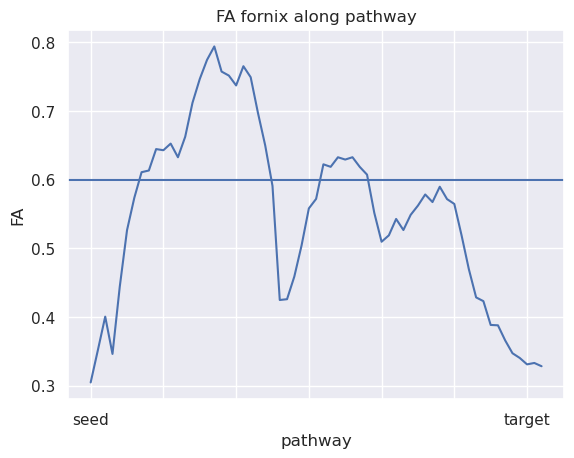

In [2]:
import pandas as pd
import nibabel as nib
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
from scipy import stats
sns.set_theme(style="darkgrid")

roi = "lh.fx"

df = pd.read_csv(f"../study/freesurfer/VNSLC_02/dpath/{roi}_avg16_syn_bbr/pathstats.byvoxel.txt", delimiter=" ", comment="#")
map = nib.load(f"../study/freesurfer/VNSLC_02/dpath/{roi}_avg16_syn_bbr/path.map.nii.gz")
map = map.get_fdata()
print(np.sum(map != 0))

full = nib.load(f"../study/freesurfer/VNSLC_02/dpath/{roi}_avg16_syn_bbr/path.pd.nii.gz")
full = full.get_fdata()
print(np.sum(full != 0))

df = df.drop_duplicates()
df.filter(regex=r'FA')
df.insert(0, "points", range(0, len(df)))

ax = sns.lineplot(data=df, x="points", y="FA_Avg")
plt.axhline(y=0.599205)
ax.set_xlabel("pathway")
ax.set_xticklabels(["", "seed", "", "", "", "", "", "target"])
ax.set_ylabel("FA")
ax.set_title(f"FA fornix along pathway")

# plt.savefig(f"../imgs/FA-fornix-pathway.png", pad_inches=0, bbox_inches="tight", dpi=150)

# ax = sns.displot(data=df, y="FA_Avg", kde=True)
# plt.axhline(y=0.599205)
# ax.set(ylabel=None)
# plt.title(f"FA {roi} distribution")

# plt.savefig(f"../imgs/FA-opticRadiation-distribution.png", pad_inches=0, bbox_inches="tight", dpi=150)

data = df["FA_Avg"]
print(np.mean(data), np.std(data), stats.skew(data, bias=False), stats.kurtosis(data, fisher=True, bias=False))



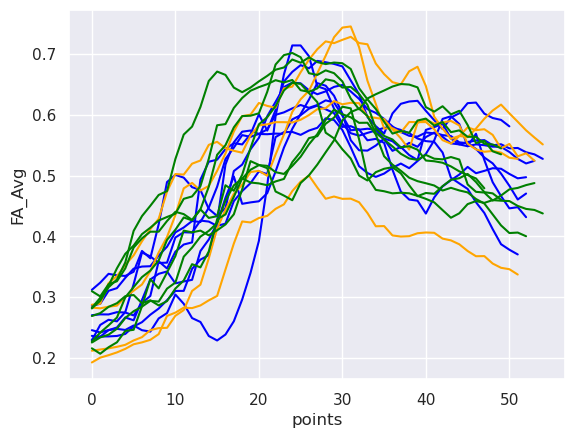

In [3]:
import pandas as pd
import nibabel as nib
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
from scipy import stats
sns.set_theme(style="darkgrid")

roi = "rh.mlf"

resp = [1, 2, 3, 4, 7, 9, 11]
partResp = [10, 12, 14, 15]
nonResp = [6, 13, 17, 18, 19, 22, 23]

full_df = pd.DataFrame()

for pat in nonResp:

    df = pd.read_csv(f"../study/freesurfer/VNSLC_{pat:02}/dpath/{roi}_avg16_syn_bbr/pathstats.byvoxel.txt", delimiter=" ", comment="#")

    df = df.drop_duplicates()
    df.insert(0, "points", range(0, len(df)))
    df.insert(0, "resp", 0)
    full_df = pd.concat([full_df, df], axis=0, ignore_index=True)

    ax = sns.lineplot(data=df, x="points", y="FA_Avg", c="blue")

for pat in partResp:

    df = pd.read_csv(f"../study/freesurfer/VNSLC_{pat:02}/dpath/{roi}_avg16_syn_bbr/pathstats.byvoxel.txt", delimiter=" ", comment="#")

    df = df.drop_duplicates()
    df.insert(0, "points", range(0, len(df)))
    df.insert(0, "resp", 1)
    full_df = pd.concat([full_df, df], axis=0, ignore_index=True)

    ax = sns.lineplot(data=df, x="points", y="FA_Avg", c="orange")

#for pat in [*resp,*partResp]:
for pat in resp:

    df = pd.read_csv(f"../study/freesurfer/VNSLC_{pat:02}/dpath/{roi}_avg16_syn_bbr/pathstats.byvoxel.txt", delimiter=" ", comment="#")

    df = df.drop_duplicates()
    df.insert(0, "points", range(0, len(df)))
    df.insert(0, "resp", 2)
    full_df = pd.concat([full_df, df], axis=0, ignore_index=True)

    ax = sns.lineplot(data=df, x="points", y="FA_Avg", c="green")

/tmp/ipykernel_470563/762930474.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "seed", "", "", "", "", "target"])


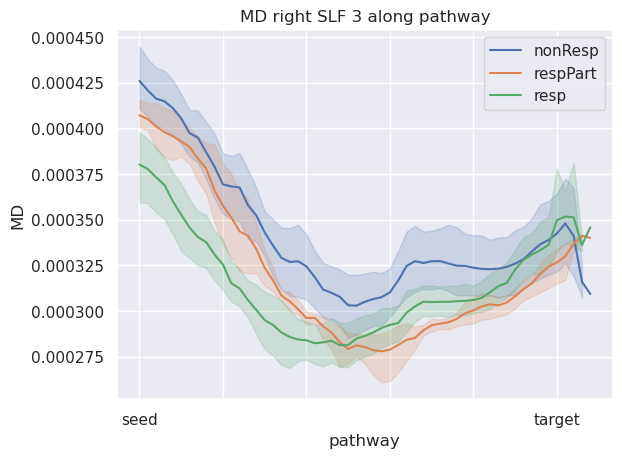

In [4]:
ax = sns.lineplot(data=full_df, x="points", y="MD_Avg", hue="resp", palette="deep")
ax.set_xlabel("pathway")
ax.set_xticklabels(["", "seed", "", "", "", "", "target"])
ax.set_ylabel("MD")
ax.set_title(f"MD right SLF 3 along pathway")
legend = ax.legend()
legend.get_texts()[0].set_text("nonResp")
legend.get_texts()[1].set_text("respPart")
legend.get_texts()[2].set_text("resp")

# plt.savefig(f"../imgs/MD_right_SLF3-pathway-mean-full.png", pad_inches=0, bbox_inches="tight", dpi=150)